# `Enron-Spam Prediction`

`Aan Nurliyanah`

## Import Library

In [1]:
!pip install tensorflow

# untuk perhitungan data, pengolahan data, dan visualisasi data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns


# untuk spliting data
from sklearn.model_selection import train_test_split

# untuk preprocessing data
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.layers import TextVectorization, Embedding
import string
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer


# untuk definisi model 
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling1D, Input, Dropout, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

# untuk menampilkan data teks secara visual
from wordcloud import WordCloud

# untuk evaluasi model 
from sklearn.metrics import roc_curve,roc_auc_score,precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score, ConfusionMatrixDisplay


# untuk import model 
import pickle

from sklearn.datasets import load_files

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Data Loading and Overview

The dataset source is from kaggle :

https://www.kaggle.com/datasets/wanderfj/enron-spam

In [2]:
!mkdir ~/.kaggle

In [3]:
!cp /content/kaggle.json ~/.kaggle

In [4]:
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


Download the data using API from kaggle

In [5]:
!kaggle datasets download -d wanderfj/enron-spam

 87% 25.0M/28.8M [00:00<00:00, 131MB/s] 
100% 28.8M/28.8M [00:00<00:00, 130MB/s]


In [6]:
!unzip -q /content/enron-spam.zip -d dataset

In [7]:
X, y  = [], []
for i in range(1,7):
    emails = load_files(f"../content/dataset/enron{i}",encoding= 'UTF-8',decode_error= 'replace')
    
    X = np.append(X, emails.data)
    y = np.append(y, emails.target)

classes = emails.target_names

In [8]:
print(f"X.shape: {X.shape:}")
print(f"y.shape: {y.shape}")
print("\n")
print(f"Example X[0]: {X[0]}")
print("\n")
print(f"Class X[0]: {y[0]} ({classes[int(y[0])]})")

X.shape: (33715,)
y.shape: (33715,)


Example X[0]: Subject: nesa / hea ' s 24 th annual meeting
saddle up for nesa / hea ' s 24 th annual meeting
" deep in the heart of texas "
september 9 - 11 , 2001
hyatt regency hill country resort
san antonio , texas
the annual meeting planning committee has put together an outstanding
program for your review . it is attached below in an adobe acrobat pdf file
- if you have problems with the attachment please call nesa / hea
headquarters at ( 713 ) 856 - 6525 and we ' ll mail or fax a copy out immediately .
general session topics include :
* will tomorrow ' s restructured electric infrastructure support
tomorrow ' s economy ?
* power deregulation panel : developer / ipp , utility / transmission , power
marketer , government , retail
* power demand
* the state of the energy industry
* new political administration - impact on energy policy and
environment
networking opportunities :
* opening reception - sunday , september 9
* golf tournament & tours

Convert into dataframe

In [9]:
dic = {'text':X,'class':y}
data = pd.DataFrame(dic)
data.head()

,text,class
0,Subject: nesa / hea ' s 24 th annual meeting\r...,0.0
1,Subject: meter 1431 - nov 1999\r\ndaren -\r\nc...,0.0
2,Subject: investor here .\r\nfrom : mr . richar...,1.0
3,Subject: hi paliourg all available meds . avai...,1.0
4,Subject: january nominations at shell deer par...,0.0


In [10]:
data.tail()

,text,class
33710,Subject: congratulations ! ! ! ! you have won\...,1.0
33711,Subject: new pharm site new great prices humbe...,1.0
33712,Subject: do you remember us ?\r\n- easily lose...,1.0
33713,"Subject: pre - approved application sun , 07 n...",1.0
33714,"Subject: stop the inexpensive , get med ' cine...",1.0


In [11]:
data.shape

(33715, 2)

Checking missing value

In [12]:
data.isnull().sum()

text     0
class    0
dtype: int64

Checking duplicated data

In [13]:
data[data.duplicated()].shape

(3222, 2)

General overview :

- there is no missing value 
- There are some duplicated data 

## Data Cleaning

make the original data save

In [14]:
data_clean = data.copy()

In [15]:
data_clean.duplicated().any()

True

Check the duplicated data further 

In [16]:
pd.concat(g for _, g in data_clean.groupby("text") if len(g) > 1)

,text,class
149,Subject: \r\n,1.0
668,Subject: \r\n,1.0
671,Subject: \r\n,1.0
1120,Subject: \r\n,1.0
1195,Subject: \r\n,1.0
...,...,...
22991,"Subject: yyyy , do you know the hgh difference...",1.0
10953,"Subject: zwarte lijst winkelpersoneel - 42 , 6...",1.0
23050,"Subject: zwarte lijst winkelpersoneel - 42 , 6...",1.0
15978,Subject: ���� � � � � � � � ���� � � ����� � �...,1.0


We will drop the duplicated data

In [17]:
data_clean.drop_duplicates(inplace=True)
data_clean.shape

(30493, 2)

In [18]:
data_clean.duplicated().any()

False

In [19]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30493 entries, 0 to 33714
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   text    30493 non-null  object 
 1   class   30493 non-null  float64
dtypes: float64(1), object(1)
memory usage: 714.7+ KB


Change target from float to integer 

In [20]:
data_clean['class'] = data_clean['class'].astype(int)

In [21]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30493 entries, 0 to 33714
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    30493 non-null  object
 1   class   30493 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 714.7+ KB


## Exploratory Data Analysis

See the target visualization 

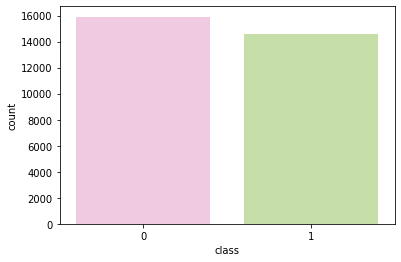

In [ ]:
sns.countplot(data=data_clean,x='class',palette="PiYG")

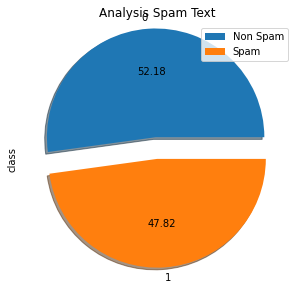

In [ ]:
plt.figure(figsize = (8,5),facecolor='white')
data_clean['class'].value_counts().plot(kind = 'pie',explode = [0.2,0.0], shadow = True,autopct = "%.2f",title='Analysis Spam Text')
plt.legend(['Non Spam','Spam'])
plt.show()

The target has a quite balance data 

## Data Preprocessing

In [22]:
data_clean.head(2)

,text,class
0,Subject: nesa / hea ' s 24 th annual meeting\r...,0
1,Subject: meter 1431 - nov 1999\r\ndaren -\r\nc...,0


In [23]:
# Melihat Teks Pertama

print(data_clean.text[0])

Subject: nesa / hea ' s 24 th annual meeting
saddle up for nesa / hea ' s 24 th annual meeting
" deep in the heart of texas "
september 9 - 11 , 2001
hyatt regency hill country resort
san antonio , texas
the annual meeting planning committee has put together an outstanding
program for your review . it is attached below in an adobe acrobat pdf file
- if you have problems with the attachment please call nesa / hea
headquarters at ( 713 ) 856 - 6525 and we ' ll mail or fax a copy out immediately .
general session topics include :
* will tomorrow ' s restructured electric infrastructure support
tomorrow ' s economy ?
* power deregulation panel : developer / ipp , utility / transmission , power
marketer , government , retail
* power demand
* the state of the energy industry
* new political administration - impact on energy policy and
environment
networking opportunities :
* opening reception - sunday , september 9
* golf tournament & tours of area attractions - monday , september 10
the hya

### Lowercase

In [24]:
# Ubah teks ke lowercase

teks = data_clean.text[0]
teks_lower = teks.lower()
teks_lower

'subject: nesa / hea \' s 24 th annual meeting\r\nsaddle up for nesa / hea \' s 24 th annual meeting\r\n" deep in the heart of texas "\r\nseptember 9 - 11 , 2001\r\nhyatt regency hill country resort\r\nsan antonio , texas\r\nthe annual meeting planning committee has put together an outstanding\r\nprogram for your review . it is attached below in an adobe acrobat pdf file\r\n- if you have problems with the attachment please call nesa / hea\r\nheadquarters at ( 713 ) 856 - 6525 and we \' ll mail or fax a copy out immediately .\r\ngeneral session topics include :\r\n* will tomorrow \' s restructured electric infrastructure support\r\ntomorrow \' s economy ?\r\n* power deregulation panel : developer / ipp , utility / transmission , power\r\nmarketer , government , retail\r\n* power demand\r\n* the state of the energy industry\r\n* new political administration - impact on energy policy and\r\nenvironment\r\nnetworking opportunities :\r\n* opening reception - sunday , september 9\r\n* golf t

### Punctuation 

In [25]:
# Menghilangkan Tanda Baca
teks_punc = teks_lower.translate(str.maketrans('','',string.punctuation))
teks_punc

'subject nesa  hea  s 24 th annual meeting\r\nsaddle up for nesa  hea  s 24 th annual meeting\r\n deep in the heart of texas \r\nseptember 9  11  2001\r\nhyatt regency hill country resort\r\nsan antonio  texas\r\nthe annual meeting planning committee has put together an outstanding\r\nprogram for your review  it is attached below in an adobe acrobat pdf file\r\n if you have problems with the attachment please call nesa  hea\r\nheadquarters at  713  856  6525 and we  ll mail or fax a copy out immediately \r\ngeneral session topics include \r\n will tomorrow  s restructured electric infrastructure support\r\ntomorrow  s economy \r\n power deregulation panel  developer  ipp  utility  transmission  power\r\nmarketer  government  retail\r\n power demand\r\n the state of the energy industry\r\n new political administration  impact on energy policy and\r\nenvironment\r\nnetworking opportunities \r\n opening reception  sunday  september 9\r\n golf tournament  tours of area attractions  monday 

### Other Preprocessing

In [26]:
# Preprocessing Lain ,menghilangkan tanda baca, emoji,simbol, dll

teks_punc = re.sub("@[A-Za-z0-9_]+"," ", teks_punc) #Menghilangkan mention
teks_punc = re.sub("[^\w\s]*[_,.!?#&;:><+-/)/(\'\"]", " ", teks_punc) 
teks_punc = re.sub("#[A-Za-z0-9_]+"," ", teks_punc) #Menghilangkan hashtag
teks_punc = re.sub(" +", " ", teks_punc.strip())   # Remove unnecessary white space 
teks_punc = re.sub(r"\n"," ",teks_punc) #Menghilangkan \n
teks_punc = teks_punc.strip() #Menghilangkan whitespace
teks_punc = re.sub(r"http\S+", " ", teks_punc) #Menghilangkan link
teks_punc = re.sub(r"www.\S+", " ", teks_punc) #Menghilangkan link
teks_punc = re.sub("[^A-Za-z\s']"," ", teks_punc) #Menghilangkan yang bukan huruf
teks_punc = re.sub("rt"," ",teks_punc) #Menghilangkan RT
teks_punc = re.sub("$", " ", teks_punc)#menghilangkan simbol mata uang
teks_punc = re.sub("€", " ", teks_punc)# menghilangkan simbol mata uang

emoji = re.compile("["
        u"\U0001F600-\U0001F64F"    # emoticons
        u"\U0001F300-\U0001F5FF"    # symbols & pictographs
        u"\U0001F680-\U0001F6FF"    # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"    # flags (iOS)
        u"\U00002500-\U00002BEF"    # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"                   # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
teks_punc = re.sub(emoji, '', teks_punc)                                                   # menghilangkan emoji
teks_punc = re.sub(r'(.)\1{2,}', r'\1', teks_punc)                                        # mengubah huruf berulang diatas 2 kali menjadi 1 saja
teks_punc = re.sub("[0-9]", " ", teks_punc)                                               # menghilangkan numbers
teks_punc = re.sub("'s", " ", teks_punc) 
teks_punc = re.sub("[¹²³¹⁰ⁱ⁴⁵⁶⁷⁸⁹⁺⁻⁼⁽⁾ⁿ]", "", teks_punc)
teks_punc = re.sub(r"can\'t", "can not", teks_punc)
teks_punc = re.sub(r"n\'t", " not", teks_punc)
teks_punc = re.sub(r"\'re", " are", teks_punc)
teks_punc = re.sub(r"\'d", " would", teks_punc)
teks_punc = re.sub(r"\'ll", " will", teks_punc)
teks_punc = re.sub(r"\'t", " not", teks_punc)
teks_punc = re.sub(r"\'m", " am",teks_punc)
teks_punc = re.sub(r"\'im", "",teks_punc)
teks_punc = re.sub(r"\'ve", " have", teks_punc)


teks_punc = ' '.join(teks_punc.split())
teks_punc

'subject nesa hea s th annual meeting saddle up for nesa hea s th annual meeting deep in the hea of texas september hyatt regency hill country reso san antonio texas the annual meeting planning committee has put together an outstanding program for your review it is attached below in an adobe acrobat pdf file if you have problems with the attachment please call nesa hea headqua ers at and we ll mail or fax a copy out immediately general session topics include will tomorrow s restructured electric infrastructure suppo tomorrow s economy power deregulation panel developer ipp utility transmission power marketer government retail power demand the state of the energy industry new political administration impact on energy policy and environment networking oppo unities opening reception sunday september golf tournament tours of area attractions monday september the hyatt regency hill country reso has a limited block of rooms available for nesa hea members and guests be sure to check page for 

### Stopwords

In [27]:
# Define Stopwords

stop_words_en = stopwords.words("english")

print('Stopwords from NLTK')
print(len(stop_words_en), stop_words_en)
print('')

## Create A New Stopwords
new_stop_words = ['aye', 'mine', 'have','im','ill','ll','subject','e','pa','de','enron','ect']

## Merge Stopwords
stop_words_en = stop_words_en + new_stop_words
stop_words_en = list(set(stop_words_en))
print('Out Final Stopwords')
print(len(stop_words_en), stop_words_en)

Stopwords from NLTK
179 ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own',

In [28]:
# Menghilangkan Stopwords

tokens = word_tokenize(teks_punc)
teks_stopwords = ' '.join([word for word in tokens if word not in stop_words_en])

print('Document     : ', teks_punc)
print('Tokens       : ', tokens)
print('Clean Tokens : ', teks_stopwords)


Document     :  subject nesa hea s th annual meeting saddle up for nesa hea s th annual meeting deep in the hea of texas september hyatt regency hill country reso san antonio texas the annual meeting planning committee has put together an outstanding program for your review it is attached below in an adobe acrobat pdf file if you have problems with the attachment please call nesa hea headqua ers at and we ll mail or fax a copy out immediately general session topics include will tomorrow s restructured electric infrastructure suppo tomorrow s economy power deregulation panel developer ipp utility transmission power marketer government retail power demand the state of the energy industry new political administration impact on energy policy and environment networking oppo unities opening reception sunday september golf tournament tours of area attractions monday september the hyatt regency hill country reso has a limited block of rooms available for nesa hea members and guests be sure to 

### Stemming

In [29]:
# Stemming

stemmer = SnowballStemmer("english")

teks_stemm = ' '.join([stemmer.stem(teks_stopwords) for teks_stopwords in teks_stopwords.split()])

print('Document       : ', teks_punc)
print('Tokens         : ', tokens)
print('Clean Tokens   : ', teks_stopwords)
print('Stemmed Tokens : ', teks_stemm)

Document       :  subject nesa hea s th annual meeting saddle up for nesa hea s th annual meeting deep in the hea of texas september hyatt regency hill country reso san antonio texas the annual meeting planning committee has put together an outstanding program for your review it is attached below in an adobe acrobat pdf file if you have problems with the attachment please call nesa hea headqua ers at and we ll mail or fax a copy out immediately general session topics include will tomorrow s restructured electric infrastructure suppo tomorrow s economy power deregulation panel developer ipp utility transmission power marketer government retail power demand the state of the energy industry new political administration impact on energy policy and environment networking oppo unities opening reception sunday september golf tournament tours of area attractions monday september the hyatt regency hill country reso has a limited block of rooms available for nesa hea members and guests be sure t

### Preprocessing ke seluruh dataframe

In [30]:
# Membuat Sebuah Function Agar Dapat Diterapkan pada DataFrame
def clean_text(text):
 
  text = text.lower()
  text = text.translate(str.maketrans("","",string.punctuation))  

  text = re.sub("@[A-Za-z0-9_]+"," ", text) #Menghilangkan mention
  text = re.sub("[^\w\s]*[_,.!?#&;:><+-/)/(\'\"]", " ", text) 
  text = re.sub("#[A-Za-z0-9_]+"," ", text) #Menghilangkan hashtag
  text = re.sub(" +", " ", text.strip())   # Remove unnecessary white space 
  text = re.sub(r"\n"," ",text) #Menghilangkan \n
  text = text.strip() #Menghilangkan whitespace
  text = re.sub(r"http\S+", " ", text) #Menghilangkan link
  text = re.sub(r"www.\S+", " ", text) #Menghilangkan link
  text = re.sub("[^A-Za-z\s']"," ", text) #Menghilangkan yang bukan huruf
  text = re.sub("rt"," ",text) #Menghilangkan RT
  text = re.sub("$", " ", text)
  text = re.sub("€", " ", text)

  emoji = re.compile("["
          u"\U0001F600-\U0001F64F"    # emoticons
          u"\U0001F300-\U0001F5FF"    # symbols & pictographs
          u"\U0001F680-\U0001F6FF"    # transport & map symbols
          u"\U0001F1E0-\U0001F1FF"    # flags (iOS)
          u"\U00002500-\U00002BEF"    # chinese char
          u"\U00002702-\U000027B0"
          u"\U00002702-\U000027B0"
          u"\U000024C2-\U0001F251"
          u"\U0001f926-\U0001f937"
          u"\U00010000-\U0010ffff"
          u"\u2640-\u2642" 
          u"\u2600-\u2B55"
          u"\u200d"
          u"\u23cf"
          u"\u23e9"
          u"\u231a"
          u"\ufe0f"                   # dingbats
          u"\u3030"
                        "]+", re.UNICODE)
  text = re.sub(emoji, '', text)                                                   # remove emoji
  text = re.sub(r'(.)\1{2,}', r'\1', text)                                        # mengubah huruf berulang diatas 2 kali menjadi 1 saja
  text = re.sub("[0-9]", " ", text)                                               # remove numbers
  text = re.sub("'s", " ", text) 
  text = re.sub("[¹²³¹⁰ⁱ⁴⁵⁶⁷⁸⁹⁺⁻⁼⁽⁾ⁿ]", "", text)
  text = re.sub(r"can\'t", "can not", text)
  text = re.sub(r"n\'t", " not", text)
  text = re.sub(r"\'re", " are", text)
  text = re.sub(r"\'d", " would", text)
  text = re.sub(r"\'ll", " will", text)
  text = re.sub(r"\'t", " not", text)
  text = re.sub(r"\'m", " am",text)
  text = re.sub(r"\'im", "",text)
  text = re.sub(r"\'ve", " have", text)
  text = ' '.join(text.split())

  tokens = word_tokenize(text)
  text = ' '.join([word for word in tokens if word not in stop_words_en])
  text = ' '.join([stemmer.stem(text) for text in text.split()])
  return text


In [31]:
# Mengaplikasikan Semua Teknik Preprocessing ke dalam Semua Documents
def cleaner(data_clean):
    data_clean['preprocessed'] = data_clean['text'].apply(lambda x: clean_text(x))
    return data_clean

cleaner(data_clean)

data_clean.head()

,text,class,preprocessed
0,Subject: nesa / hea ' s 24 th annual meeting\r...,0,nesa hea th annual meet saddl nesa hea th annu...
1,Subject: meter 1431 - nov 1999\r\ndaren -\r\nc...,0,meter nov daren could pleas resolv issu howard...
2,Subject: investor here .\r\nfrom : mr . richar...,1,investor mr richard mayer dear friend mr richa...
3,Subject: hi paliourg all available meds . avai...,1,hi paliourg avail med avail binaur cvonyy wake...
4,Subject: january nominations at shell deer par...,0,januari nomin shell deer park fyi request day ...


In [32]:
# Melihat Target Corpus
data_clean['class'].unique()

array([0, 1])

## Tokenization & Word Embedding

In [33]:

# Splitting Corpus

X_train, X_test, y_train, y_test = train_test_split(data_clean.preprocessed, 
                                                    data_clean['class'], 
                                                    test_size=0.25, 
                                                    random_state=46, 
                                                    stratify=data_clean['class'])

print('Train Size : ', X_train.shape)
print('Test Size  : ', X_test.shape)

Train Size :  (22869,)
Test Size  :  (7624,)


### CountVectorizer

In [34]:
# Get Vocabularies

Vectorize = CountVectorizer()
X_train_vec = Vectorize.fit_transform(X_train)
X_test_vec = Vectorize.transform(X_test)

X_train_vec

<22869x98538 sparse matrix of type '<class 'numpy.int64'>'
	with 1857154 stored elements in Compressed Sparse Row format>

In [35]:
# Mencari Jumlah Vocab dan Panjang Token dalam Satu Document

jml_vocab = len(Vectorize.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in X_train])

print("Jumlah vocab:",jml_vocab)
print("Panjang maksimum kalimat:",max_sen_len,"kata")

Jumlah vocab: 98538
Panjang maksimum kalimat: 20588 kata


### TextVectorization

In [36]:
# Text Vectorization

text_vectorization = TextVectorization(max_tokens=jml_vocab,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_sen_len,
                                       input_shape=(1,) # jika ingin menggunakan sequential API
                                       )

text_vectorization.adapt(X_train)

In [37]:
# Contoh Text Vectorization

## Contoh Document
print('Contoh Document')
print(data_clean.preprocessed[0])
print('')

## Hasil Text Vectorization
print('Hasil Text Vectorization')
print(text_vectorization([data_clean.preprocessed[0]]))
print('Ukuran vector : ', text_vectorization([data_clean.preprocessed[0]]).shape)

Contoh Document
nesa hea th annual meet saddl nesa hea th annual meet deep hea texa septemb hyatt regenc hill countri reso san antonio texa annual meet plan committe put togeth outstand program review attach adob acrobat pdf file problem attach pleas call nesa hea headqua er mail fax copi immedi general session topic includ tomorrow restructur electr infrastructur suppo tomorrow economi power deregul panel develop ipp util transmiss power market govern retail power demand state energi industri new polit administr impact energi polici environ network oppo uniti open recept sunday septemb golf tournament tour area attract monday septemb hyatt regenc hill countri reso limit block room avail nesa hea member guest sure check page lodg inform make reserv soon possibl hope take oppo uniti meet colleagu custom relax yet profession environ exchang idea matter impo anc cover broad spectrum subject annual meet agenda includ time issu present knowledg industri leader discuss formid thought provok 

In [38]:
text_vectorization.get_vocabulary()[120]

'l'

In [39]:

# Melihat Top 20 Token (Diurutkan Berdasarkan Frekuensi Kemunculan Terbesar)

text_vectorization.get_vocabulary()[:20]

['',
 '[UNK]',
 'compani',
 'com',
 'pleas',
 'hou',
 'would',
 'price',
 'time',
 'inform',
 'new',
 'market',
 'may',
 'get',
 'thank',
 'busi',
 'need',
 'gas',
 'one',
 'messag']

### Embedding

In [40]:
# Embedding

embedding = Embedding(input_dim=jml_vocab,
                      output_dim=128,
                      embeddings_initializer="uniform",
                      input_length=max_sen_len
                      )

In [41]:
# Contoh Hasil Embedding

## Contoh Document
print('Contoh Document')
print(data_clean.preprocessed[0])
print('')

## Hasil Text Vectorization
print('Hasil Text Vectorization')
print(text_vectorization([data_clean.preprocessed[0]]))
print('Ukuran vector : ', text_vectorization([data_clean.preprocessed[0]]).shape)
print('')

## Hasil Embedding
print('Hasil Embedding')
print(embedding(text_vectorization([data_clean.preprocessed[0]])))
print('Ukuran vector : ', embedding(text_vectorization([data_clean.preprocessed[0]])).shape)

Contoh Document
nesa hea th annual meet saddl nesa hea th annual meet deep hea texa septemb hyatt regenc hill countri reso san antonio texa annual meet plan committe put togeth outstand program review attach adob acrobat pdf file problem attach pleas call nesa hea headqua er mail fax copi immedi general session topic includ tomorrow restructur electr infrastructur suppo tomorrow economi power deregul panel develop ipp util transmiss power market govern retail power demand state energi industri new polit administr impact energi polici environ network oppo uniti open recept sunday septemb golf tournament tour area attract monday septemb hyatt regenc hill countri reso limit block room avail nesa hea member guest sure check page lodg inform make reserv soon possibl hope take oppo uniti meet colleagu custom relax yet profession environ exchang idea matter impo anc cover broad spectrum subject annual meet agenda includ time issu present knowledg industri leader discuss formid thought provok 

### Visualisasi Wordcloud

In [42]:

# slicing
spam = data_clean[data_clean['class']==1]['preprocessed']
not_spam = data_clean[data_clean['class']==0]['preprocessed'].sample(100, random_state=0)

# merge dalam satu bracket list
join_spam = '. '.join(list(spam.values))
join_notspam = '. '.join(list(not_spam.values))


# class 1
with open('join_spam.txt', 'w') as f:
    f.write(join_spam)
# class 0
with open('join_notspam.txt', 'w') as f:
    f.write(join_notspam)

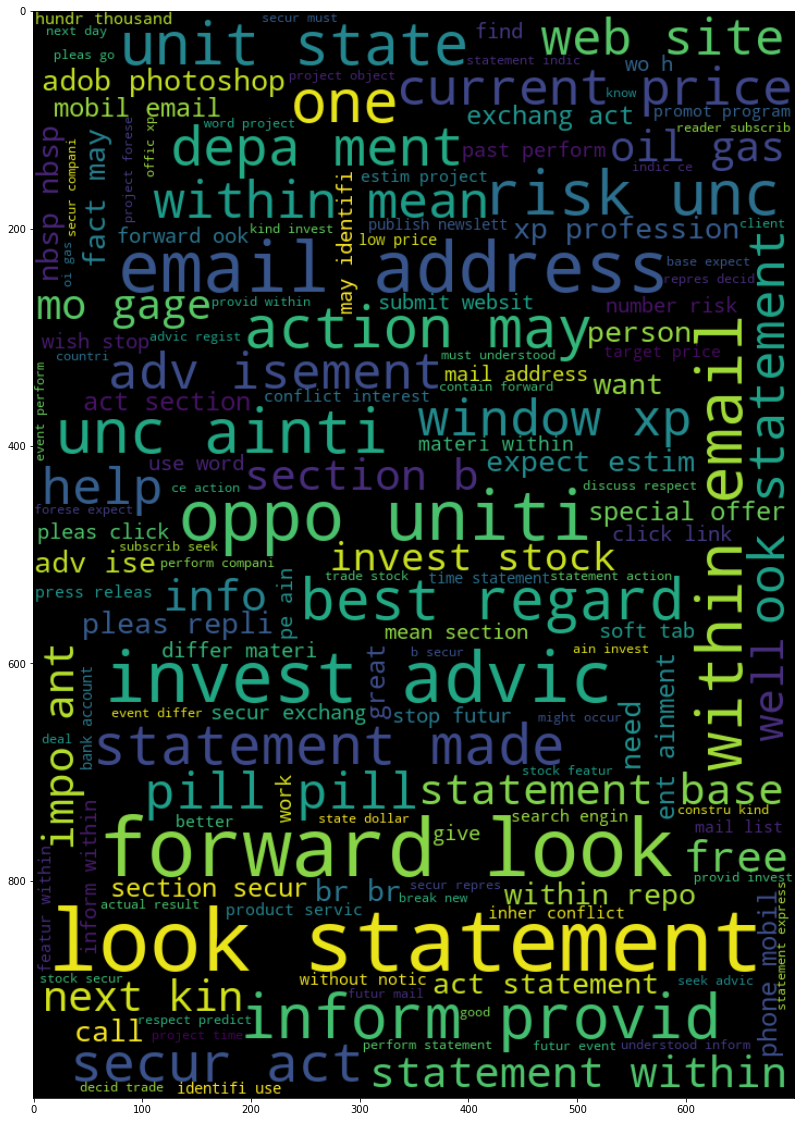

In [43]:
# kata kata spam
plt.figure(figsize = (20,20)) 

w_cloud = WordCloud(background_color='black', min_font_size = 3,
                    max_words = 150 , width = 700 ,
                    height = 1000).generate(" ".join(spam))

plt.imshow(w_cloud,interpolation = 'bilinear')

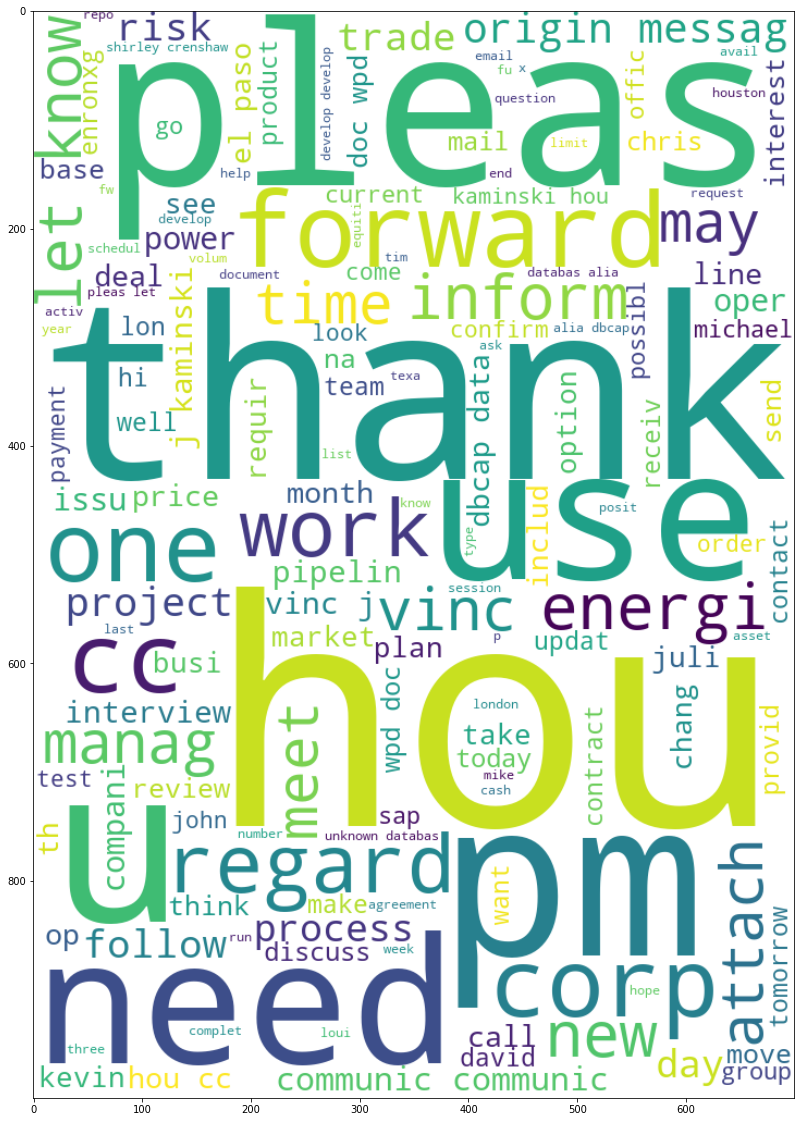

In [44]:

# kata kata not-spam
plt.figure(figsize = (20,20))

w_cloud = WordCloud(background_color='white', min_font_size = 3,
                    max_words = 150 , width = 700 ,
                    height = 1000).generate(" ".join(not_spam))

plt.imshow(w_cloud,interpolation = 'bilinear')

In [45]:

#Definisi list kata-kata pada masing2 kategori
spam_words=[]
notspam_words=[]


#Memasukkan kata-kata yang berada pada semua tweet untu masing-masing kategori
for txt in data_clean['preprocessed'][data_clean['class']==1]:
    for wrd in txt.split(' '):
        spam_words.append(wrd)

for txt in data_clean['preprocessed'][data_clean['class']==0]:
    for wrd in txt.split(' '):
        notspam_words.append(wrd)

#mengubah list menjadi pandas Series dan menghilangkan string kosong ''
spam_wd=pd.Series(spam_words)[pd.Series(spam_words)!='']
notspam_wd=pd.Series(notspam_words)[pd.Series(notspam_words)!='']

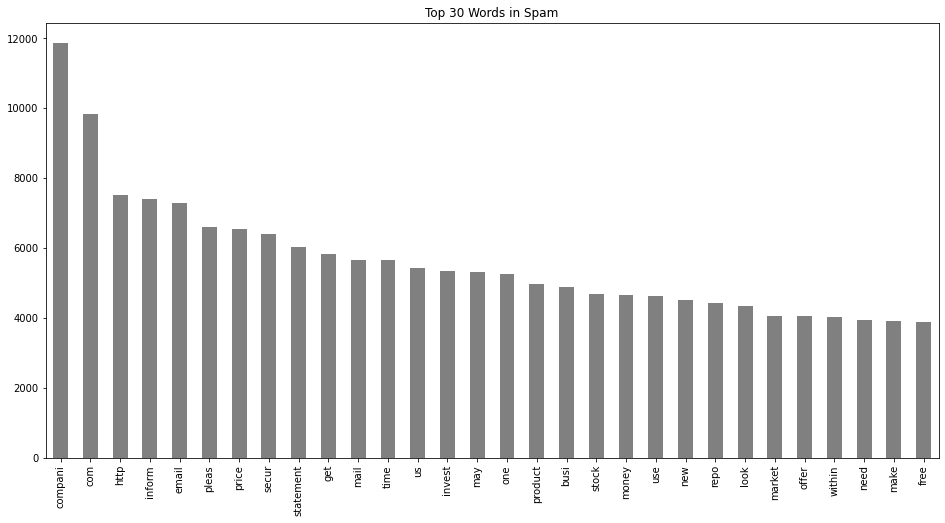

In [46]:
spam_wd.value_counts()[:30].plot(kind='bar',title='Top 30 Words in Spam',figsize=(16,8),color='grey')

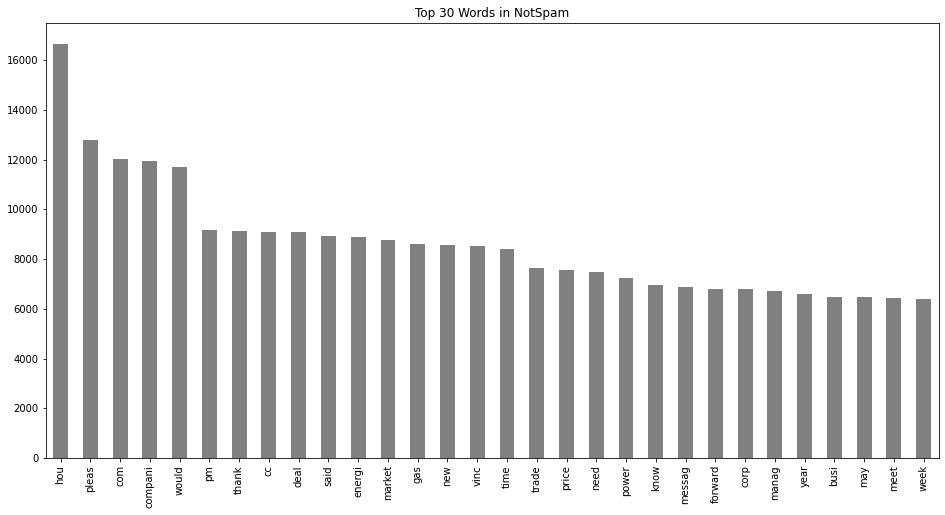

In [47]:
notspam_wd.value_counts()[:30].plot(kind='bar',title='Top 30 Words in NotSpam',figsize=(16,8),color='grey')

## Model Building

### Deep Learning - Fully Connected Layer

DNN Sequential models are used for NLP tasks because they are able to effectively capture complex relationships between input and output variables, effectively model the sequential nature of language, handle large amounts of data, learn complex representations, handle variable-length input, be used with pre-trained models, and be used for end-to-end tasks.

In [53]:
model1 = Sequential()
model1.add(text_vectorization)
model1.add(embedding)
model1.add(GlobalAveragePooling1D())
model1.add(Dense(32,activation='relu'))
model1.add(Dense(1,activation='sigmoid'))

model1.compile(loss='binary_crossentropy',optimizer='adam',metrics='accuracy')

model_dnn_hist_1 = model1.fit(X_train,
                         y_train,
                         epochs=10,batch_size=128,
                         validation_data=(X_test, y_test))

Epoch 1/10
179/179 [==============================] - 9s 46ms/step - loss: 0.6456 - accuracy: 0.6665 - val_loss: 0.5722 - val_accuracy: 0.9704
Epoch 2/10
179/179 [==============================] - 8s 45ms/step - loss: 0.4820 - accuracy: 0.9261 - val_loss: 0.3945 - val_accuracy: 0.9667
Epoch 3/10
179/179 [==============================] - 8s 45ms/step - loss: 0.3354 - accuracy: 0.9455 - val_loss: 0.2933 - val_accuracy: 0.8987
Epoch 4/10
179/179 [==============================] - 8s 45ms/step - loss: 0.2498 - accuracy: 0.9583 - val_loss: 0.2174 - val_accuracy: 0.9639
Epoch 5/10
179/179 [==============================] - 8s 45ms/step - loss: 0.1957 - accuracy: 0.9690 - val_loss: 0.1765 - val_accuracy: 0.9798
Epoch 6/10
179/179 [==============================] - 8s 45ms/step - loss: 0.1637 - accuracy: 0.9690 - val_loss: 0.1491 - val_accuracy: 0.9797
Epoch 7/10
179/179 [==============================] - 8s 45ms/step - loss: 0.1391 - accuracy: 0.9729 - val_loss: 0.1366 - val_accuracy: 0.9770

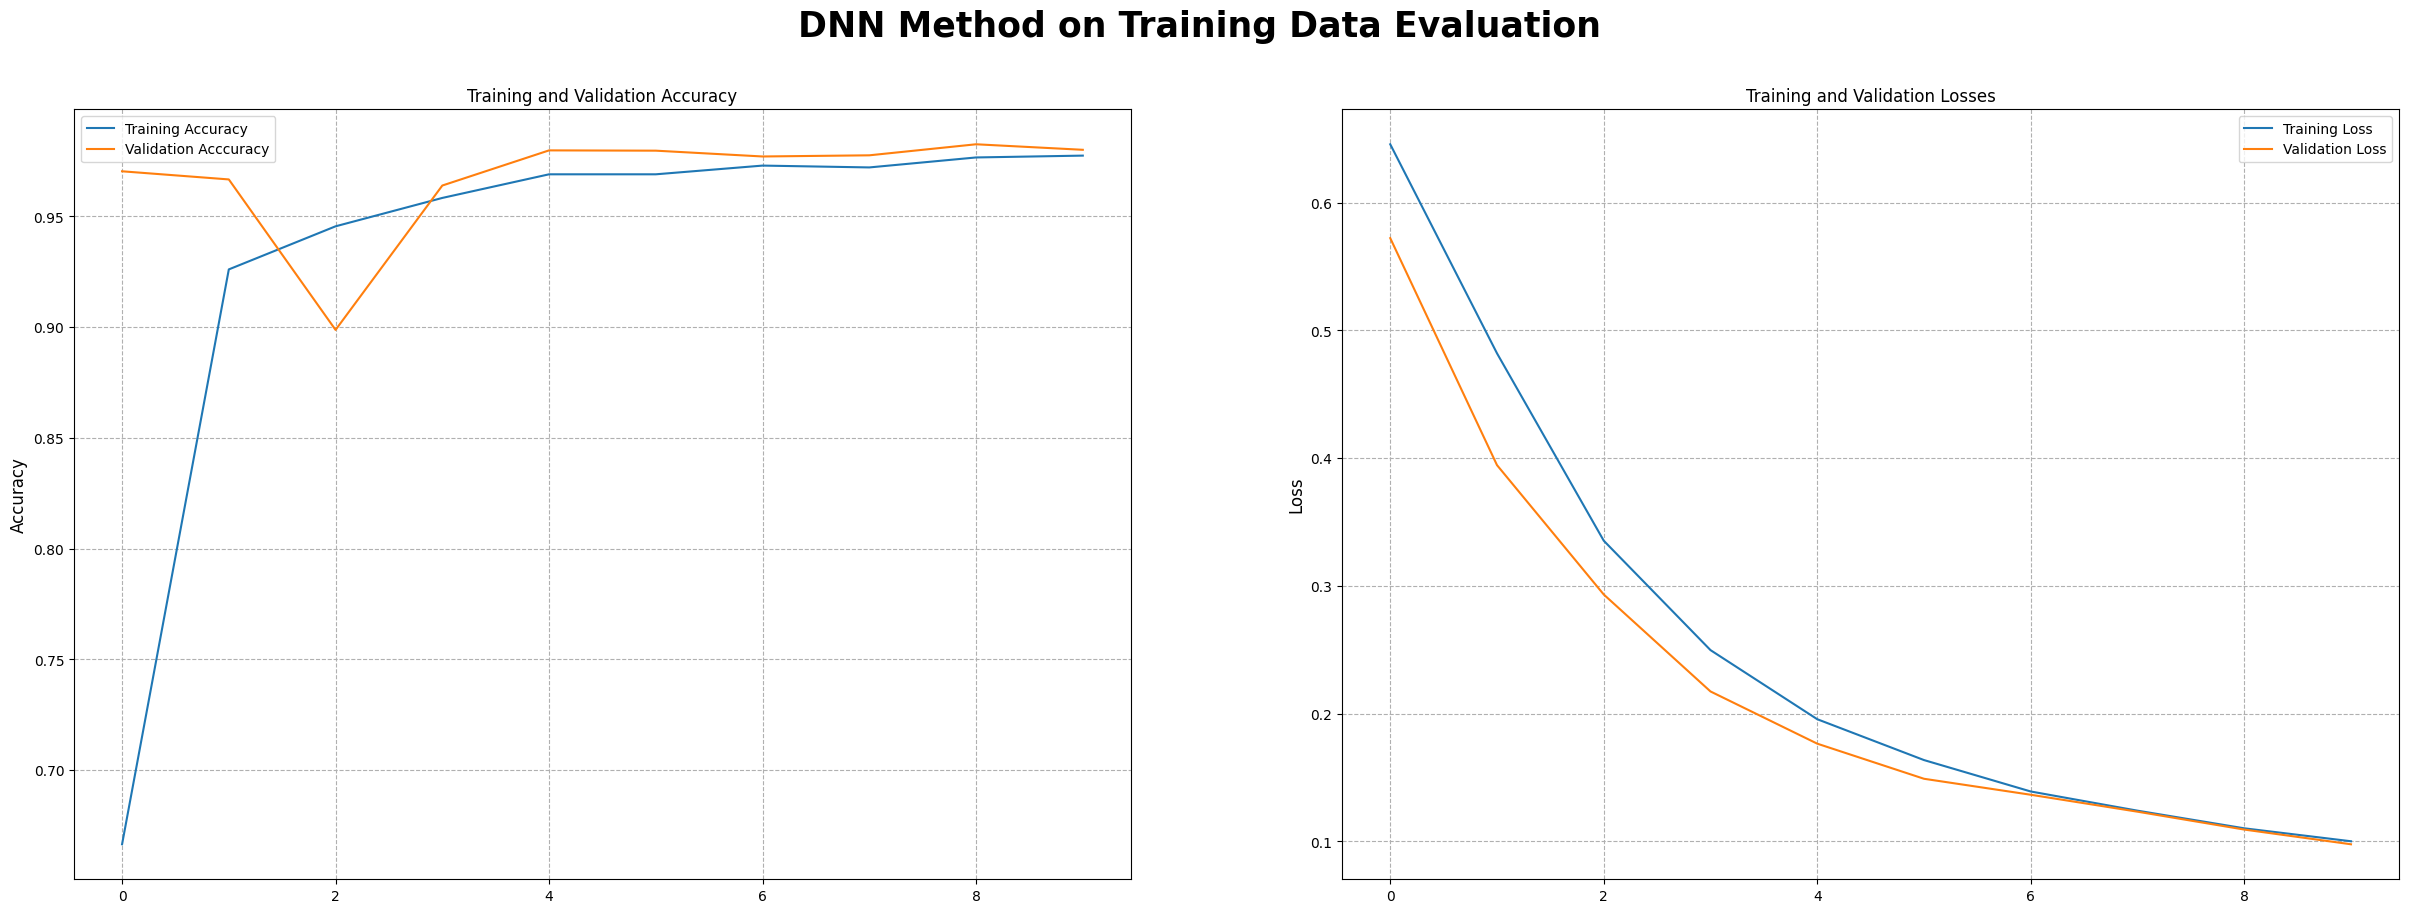

In [54]:
fig, ax = plt.subplots(1,2, figsize=(30,10))
fig.suptitle('DNN Method on Training Data Evaluation', fontsize=25, weight='bold')

plt.subplot(1,2,1)
plt.title("Training and Validation Accuracy", fontsize=12)
plt.plot(model_dnn_hist_1.history['accuracy'],label="Training Accuracy")
plt.plot(model_dnn_hist_1.history['val_accuracy'], label="Validation Acccuracy")
plt.ylabel("Accuracy", fontsize=12)
plt.legend()
plt.grid(linestyle='--')

plt.subplot(1,2,2)
plt.title("Training and Validation Losses", fontsize=12)
plt.plot(model_dnn_hist_1.history['loss'], label="Training Loss")
plt.plot(model_dnn_hist_1.history['val_loss'], label="Validation Loss")
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.grid(linestyle='--')

plt.style.use('default')
plt.show()

### LSTM

LSTM is a type of Recurrent Neural Network (RNN) is used for NLP tasks because it is able to effectively capture long-term dependencies in sequential data, handle sequential data effectively, model long-term dependencies, handle variable-length input, be used with pre-trained models, be used for end-to-end tasks and handle missing values in sequential data.

In [ ]:

# Model Training dengan Menggunakan LSTM

model = Sequential()
model.add(text_vectorization)
model.add(embedding)
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics='accuracy')

es = EarlyStopping(monitor='val_accuracy',mode='max',verbose=1,patience=3)
mc = ModelCheckpoint('checkpoint/',monitor='val_accuracy',verbose=1,mode='max',save_best_only=True)

model_lstm_hist_1 = model.fit(X_train,
                         y_train,
                         epochs=10,batch_size=128,
                         callbacks=[es,mc],
                         validation_data=(X_test, y_test))

Epoch 1/10
179/179 [==============================] - ETA: 0s - loss: 0.6925 - accuracy: 0.5194
Epoch 1: val_accuracy improved from -inf to 0.52177, saving model to checkpoint/


179/179 [==============================] - 282s 2s/step - loss: 0.6925 - accuracy: 0.5194 - val_loss: 0.6922 - val_accuracy: 0.5218
Epoch 2/10
179/179 [==============================] - ETA: 0s - loss: 0.6924 - accuracy: 0.5218
Epoch 2: val_accuracy did not improve from 0.52177
179/179 [==============================] - 265s 1s/step - loss: 0.6924 - accuracy: 0.5218 - val_loss: 0.6922 - val_accuracy: 0.5218
Epoch 3/10
179/179 [==============================] - ETA: 0s - loss: 0.6922 - accuracy: 0.5218
Epoch 3: val_accuracy did not improve from 0.52177
179/179 [==============================] - 266s 1s/step - loss: 0.6922 - accuracy: 0.5218 - val_loss: 0.6923 - val_accuracy: 0.5218
Epoch 4/10
179/179 [==============================] - ETA: 0s - loss: 0.6922 - accuracy: 0.5218
Epoch 4: val_accuracy did not improve from 0.52177
179/179 [==============================] - 267s 1s/step - loss: 0.6922 - accuracy: 0.5218 - val_loss: 0.6922 - val_accuracy: 0.5218
Epoch 4: early stopping


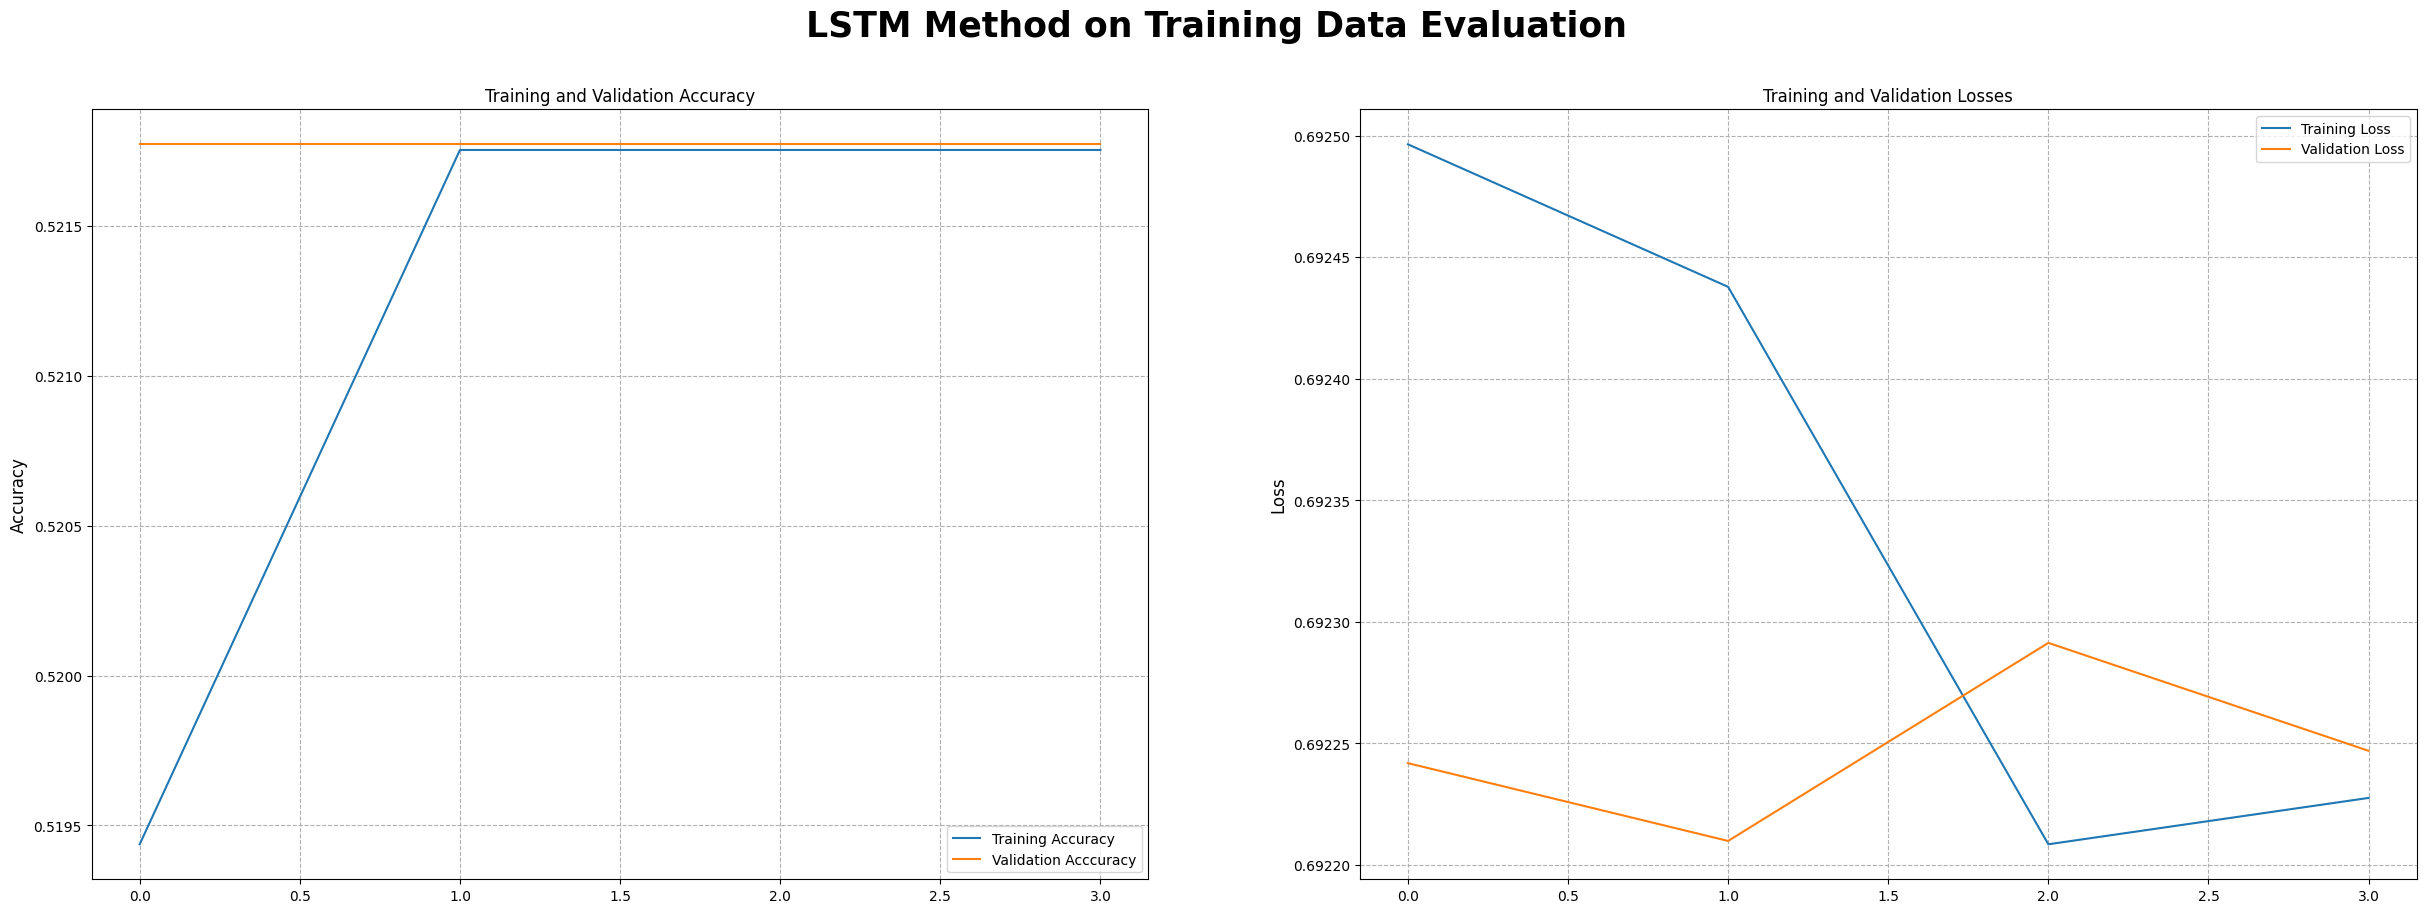

In [ ]:

fig, ax = plt.subplots(1,2, figsize=(30,10))
fig.suptitle('LSTM Method on Training Data Evaluation', fontsize=25, weight='bold')

plt.subplot(1,2,1)
plt.title("Training and Validation Accuracy", fontsize=12)
plt.plot(model_lstm_hist_1.history['accuracy'],label="Training Accuracy")
plt.plot(model_lstm_hist_1.history['val_accuracy'], label="Validation Acccuracy")
plt.ylabel("Accuracy", fontsize=12)
plt.legend()
plt.grid(linestyle='--')

plt.subplot(1,2,2)
plt.title("Training and Validation Losses", fontsize=12)
plt.plot(model_lstm_hist_1.history['loss'], label="Training Loss")
plt.plot(model_lstm_hist_1.history['val_loss'], label="Validation Loss")
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.grid(linestyle='--')

plt.style.use('default')
plt.show()

### GRU

GRU is other RNN model that used for NLP tasks because it is able to effectively capture long-term dependencies in sequential data, handle sequential data effectively, model long-term dependencies, being computationally efficient, be used with pre-trained models, be used for end-to-end tasks and handle missing values in sequential data.

In [ ]:

# Model Training dengan Menggunakan GRU

model = Sequential()
model.add(text_vectorization)
model.add(embedding)
model.add(GRU(32, return_sequences=True))
model.add(GRU(32))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics='accuracy')
es = EarlyStopping(monitor='val_accuracy',mode='max',verbose=1,patience=3)
mc = ModelCheckpoint('checkpoint/',monitor='val_accuracy',verbose=1,mode='max',save_best_only=True)

model_gru_hist_1 = model.fit(X_train,
                         y_train,
                         epochs=10,batch_size=128,
                         callbacks=[es,mc],
                         validation_data=(X_test, y_test))

Epoch 1/10
179/179 [==============================] - ETA: 0s - loss: 0.6926 - accuracy: 0.5176
Epoch 1: val_accuracy improved from -inf to 0.52177, saving model to checkpoint/


179/179 [==============================] - 292s 2s/step - loss: 0.6926 - accuracy: 0.5176 - val_loss: 0.6923 - val_accuracy: 0.5218
Epoch 2/10
179/179 [==============================] - ETA: 0s - loss: 0.6924 - accuracy: 0.5218
Epoch 2: val_accuracy did not improve from 0.52177
179/179 [==============================] - 280s 2s/step - loss: 0.6924 - accuracy: 0.5218 - val_loss: 0.6923 - val_accuracy: 0.5218
Epoch 3/10
179/179 [==============================] - ETA: 0s - loss: 0.6923 - accuracy: 0.5218
Epoch 3: val_accuracy did not improve from 0.52177
179/179 [==============================] - 281s 2s/step - loss: 0.6923 - accuracy: 0.5218 - val_loss: 0.6924 - val_accuracy: 0.5218
Epoch 4/10
179/179 [==============================] - ETA: 0s - loss: 0.6923 - accuracy: 0.5218
Epoch 4: val_accuracy did not improve from 0.52177
179/179 [==============================] - 282s 2s/step - loss: 0.6923 - accuracy: 0.5218 - val_loss: 0.6922 - val_accuracy: 0.5218
Epoch 4: early stopping


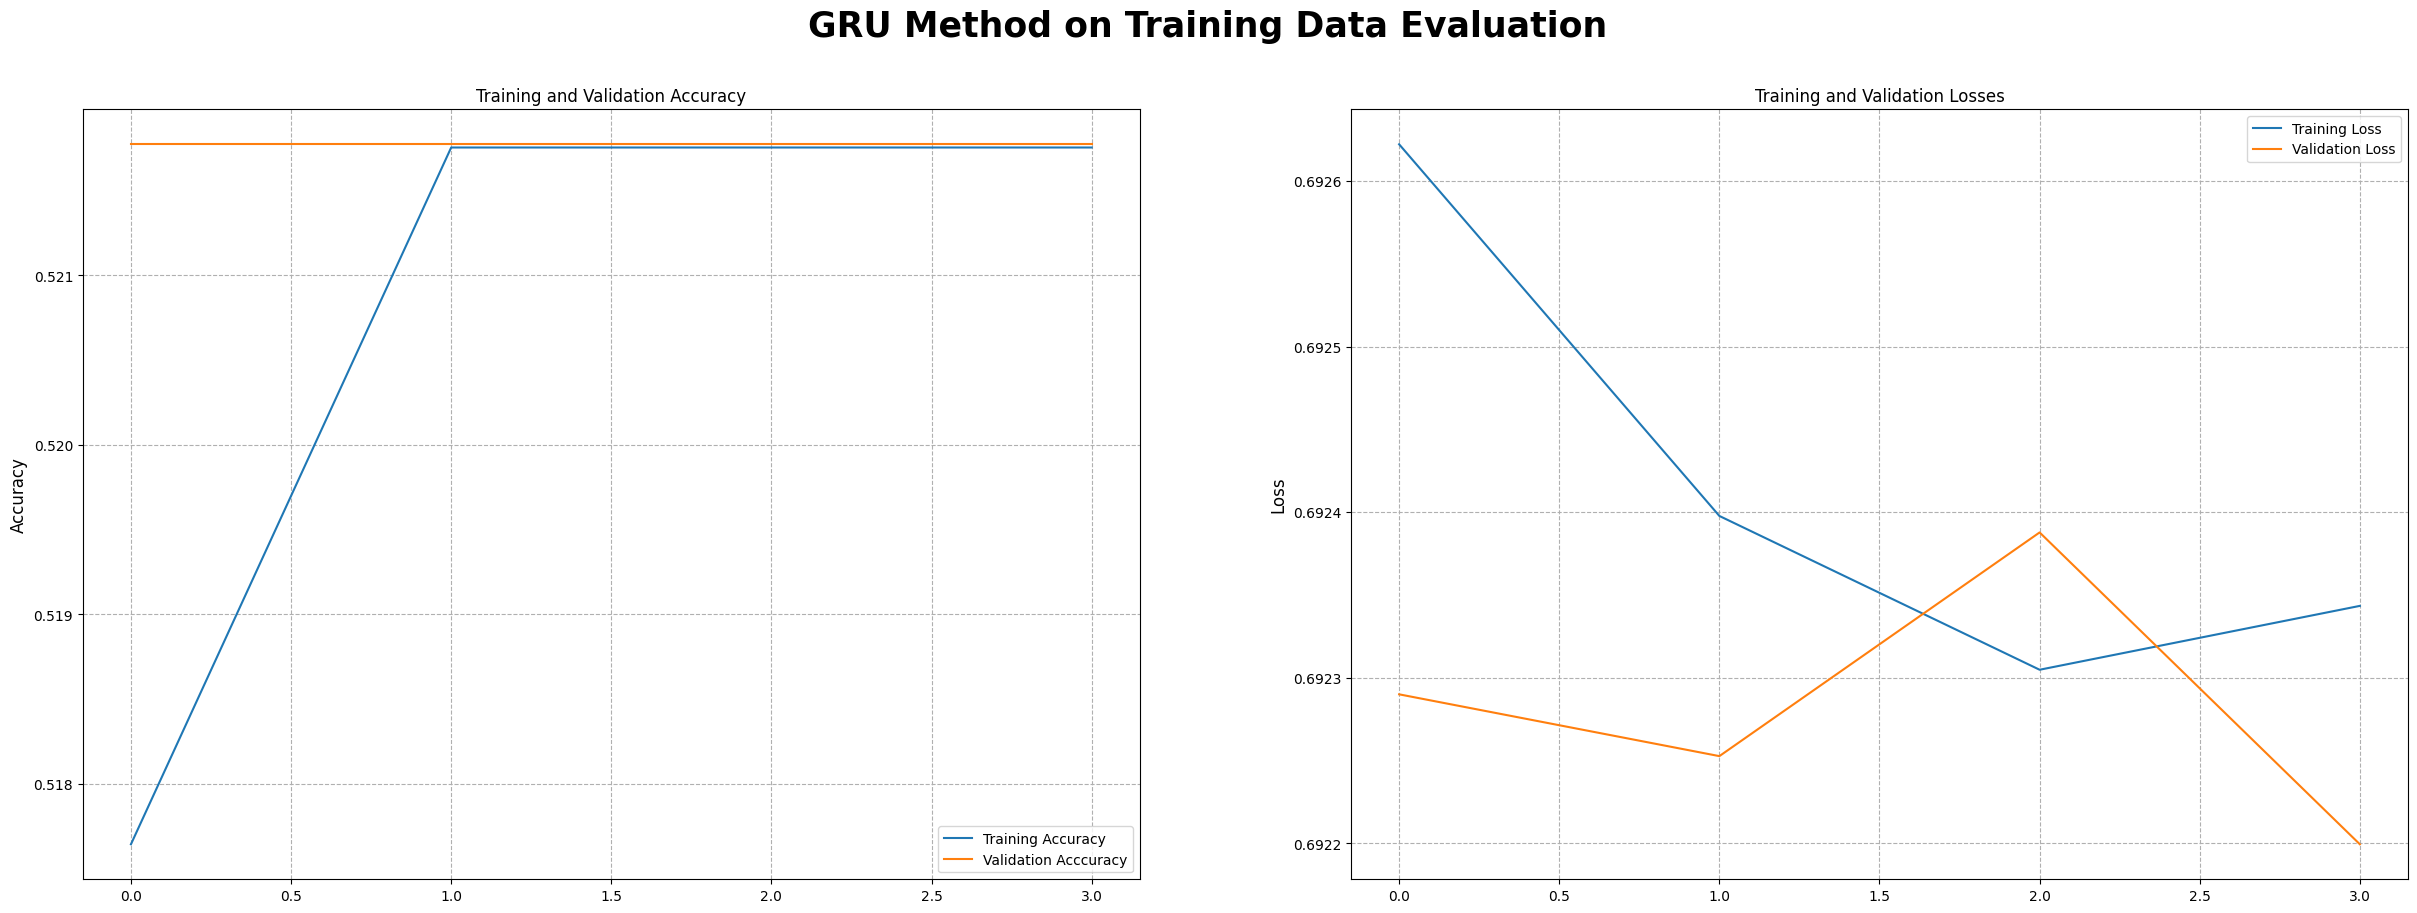

In [ ]:

fig, ax = plt.subplots(1,2, figsize=(30,10))
fig.suptitle('GRU Method on Training Data Evaluation', fontsize=25, weight='bold')

plt.subplot(1,2,1)
plt.title("Training and Validation Accuracy", fontsize=12)
plt.plot(model_gru_hist_1.history['accuracy'],label="Training Accuracy")
plt.plot(model_gru_hist_1.history['val_accuracy'], label="Validation Acccuracy")
plt.ylabel("Accuracy", fontsize=12)
plt.legend()
plt.grid(linestyle='--')

plt.subplot(1,2,2)
plt.title("Training and Validation Losses", fontsize=12)
plt.plot(model_gru_hist_1.history['loss'], label="Training Loss")
plt.plot(model_gru_hist_1.history['val_loss'], label="Validation Loss")
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.grid(linestyle='--')

plt.style.use('default')
plt.show()
     

From all model, we decided to choose the DNN model based on his performance , and we will try to improve the model. 

### Model Improvement

In [51]:
model2 = Sequential()
model2.add(text_vectorization)
model2.add(embedding)
model2.add(GlobalAveragePooling1D())
model2.add(Dense(32,activation='relu'))
model2.add(Dense(1,activation='sigmoid'))

model2.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),metrics='accuracy')
es = EarlyStopping(monitor='val_accuracy',mode='max',verbose=1,patience=3)
mc = ModelCheckpoint('checkpoint/',monitor='val_accuracy',verbose=1,mode='max',save_best_only=True)

model2_dnn_hist_2 = model2.fit(X_train,
                         y_train,
                         epochs=20,batch_size=128,
                         callbacks=[es,mc],
                         validation_data=(X_test, y_test))

Epoch 1/20
179/179 [==============================] - ETA: 0s - loss: 0.6901 - accuracy: 0.5218
Epoch 1: val_accuracy improved from -inf to 0.52190, saving model to checkpoint/
179/179 [==============================] - 10s 54ms/step - loss: 0.6901 - accuracy: 0.5218 - val_loss: 0.6872 - val_accuracy: 0.5219
Epoch 2/20
179/179 [==============================] - ETA: 0s - loss: 0.6844 - accuracy: 0.5227
Epoch 2: val_accuracy improved from 0.52190 to 0.52440, saving model to checkpoint/
179/179 [==============================] - 9s 53ms/step - loss: 0.6844 - accuracy: 0.5227 - val_loss: 0.6812 - val_accuracy: 0.5244
Epoch 3/20
179/179 [==============================] - ETA: 0s - loss: 0.6780 - accuracy: 0.5364
Epoch 3: val_accuracy improved from 0.52440 to 0.53725, saving model to checkpoint/
179/179 [==============================] - 9s 52ms/step - loss: 0.6780 - accuracy: 0.5364 - val_loss: 0.6740 - val_accuracy: 0.5373
Epoch 4/20
179/179 [==============================] - ETA: 0s - lo

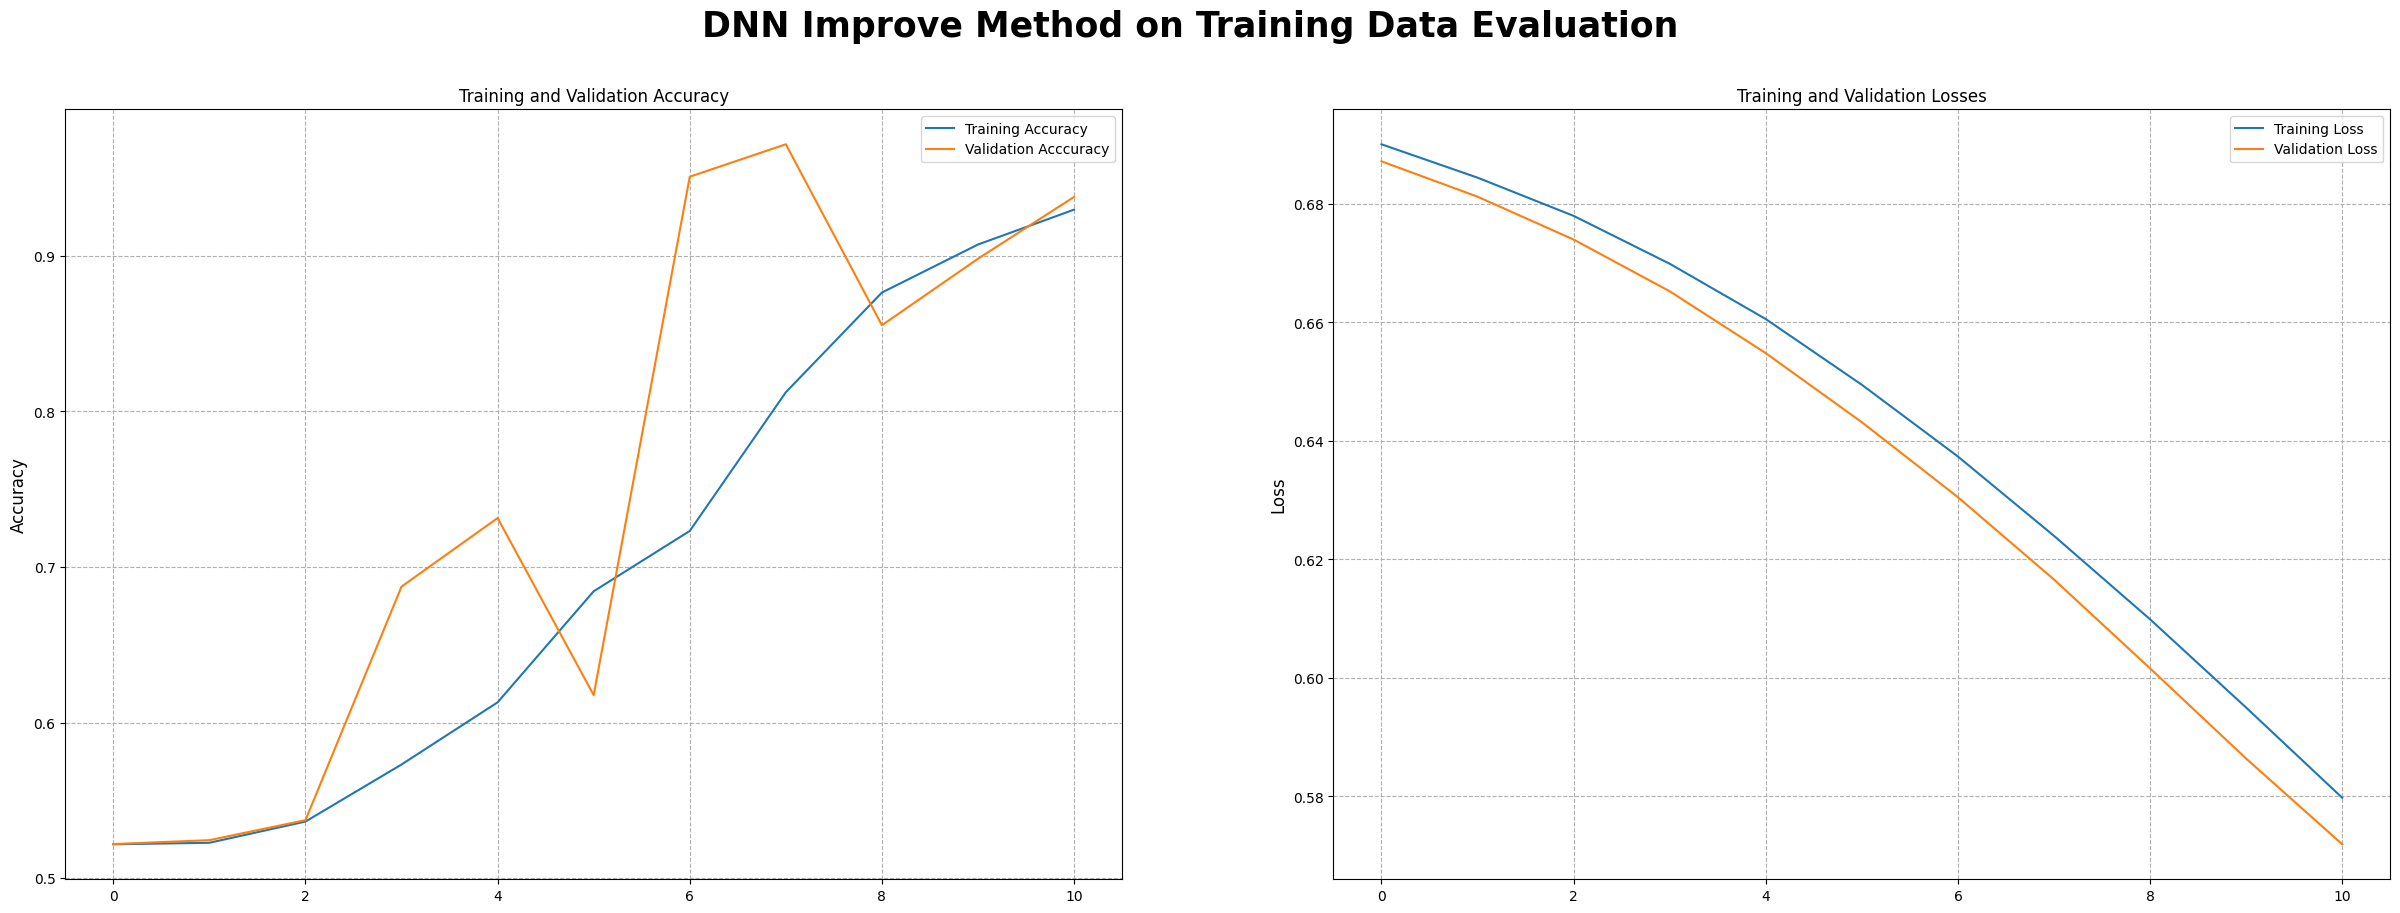

In [52]:
fig, ax = plt.subplots(1,2, figsize=(30,10))
fig.suptitle('DNN Improve Method on Training Data Evaluation', fontsize=25, weight='bold')

plt.subplot(1,2,1)
plt.title("Training and Validation Accuracy", fontsize=12)
plt.plot(model2_dnn_hist_2.history['accuracy'],label="Training Accuracy")
plt.plot(model2_dnn_hist_2.history['val_accuracy'], label="Validation Acccuracy")
plt.ylabel("Accuracy", fontsize=12)
plt.legend()
plt.grid(linestyle='--')

plt.subplot(1,2,2)
plt.title("Training and Validation Losses", fontsize=12)
plt.plot(model2_dnn_hist_2.history['loss'], label="Training Loss")
plt.plot(model2_dnn_hist_2.history['val_loss'], label="Validation Loss")
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.grid(linestyle='--')

plt.style.use('default')
plt.show()

## Model Evaluation

In [55]:
# Now we get a test dataset.
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(64)


120/120 [==============================] - 1s 7ms/step
========== TEST ==========
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3978
           1       0.97      0.99      0.98      3646

    accuracy                           0.98      7624
   macro avg       0.98      0.98      0.98      7624
weighted avg       0.98      0.98      0.98      7624



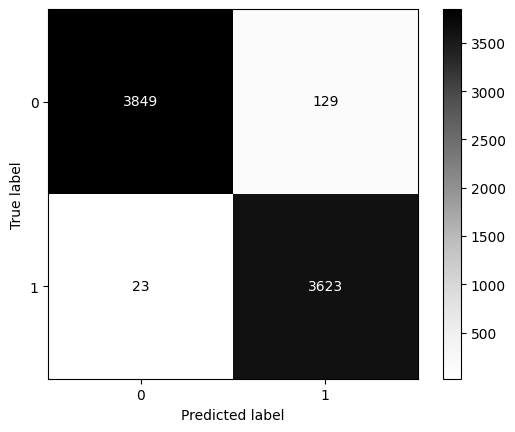

In [56]:

# predict probabilities
y_pred_sequent = model1.predict(test_dataset)
y_pred_sequent = (y_pred_sequent > 0.5)

# classification report
print("="*10,"TEST","="*10)
print(classification_report(y_test, y_pred_sequent, zero_division=0))

# confusion matrix
cm = confusion_matrix(y_test, y_pred_sequent)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,)
disp.plot(cmap='Greys')
plt.show()

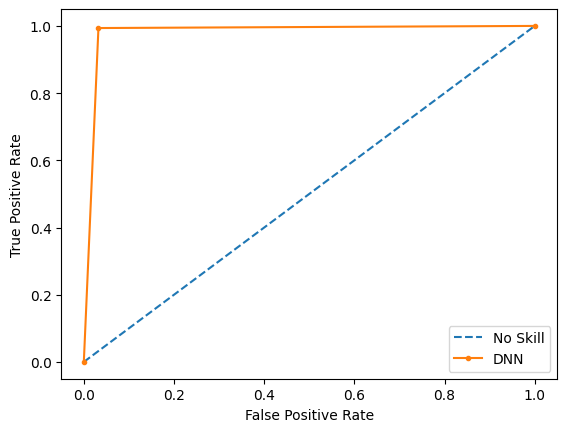

AUC score: 0.9806316804961573


In [57]:
# calculate roc curves & auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_sequent)
auc = roc_auc_score(y_test, y_pred_sequent)

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='DNN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print(f'AUC score: {auc}')

the evaluation show that the recall result is pretty good and the AUC score is 0.98

## Model Saving

In [58]:
pickle.dump(cleaner, open('cleaner.pkl','wb'))


In [59]:
pickle.dump(Vectorize, open('Vectorize.pkl','wb'))

In [61]:
model1.save('model_spam.tf')

##  Model Inference

In [62]:
# Predict New Texts

inf = {'text' : "Subject: Meet the new Customer Support Representative. Dear team,I am pleased to introduce you to [Name] who is starting today as a Customer Support Representative. She will be providing technical support and assistance to our users, making sure they enjoy the best experience with our products.Feel free to greet Shely in person and congratulate her with the new role!Best regards,Harry"}

inferences = pd.DataFrame([inf])
inferences

,text
0,Subject: Meet the new Customer Support Represe...


In [63]:
inference = cleaner(inferences)

In [64]:
inference

,text,preprocessed
0,Subject: Meet the new Customer Support Represe...,meet new custom suppo repres dear teami pleas ...


In [66]:
inf_predict = model1.predict(inference['preprocessed'])
inf_predict

1/1 [==============================] - 0s 85ms/step


array([[0.5344689]], dtype=float32)

In [67]:

# interpretation for churn
if inf_predict == 1:
    print("Spam")
else:
    print("Not Spam")

Not Spam


## Conclusion 

- The DNN model perform the best from all the models, it have accuracy 0.98 %. the model can learn complex representations. DNN Sequential models are able to learn high-level representations of the input data, which are useful for understanding the meaning of the text. The model can predict the spam or not spam in the text . 
- The obstacles is that they can be computationally expensive to train and deploy, especially for large datasets or complex tasks. Another weakness is that DNNs can be prone to overfitting, particularly when the amount of training data is limited. Additionally, DNNs are often not able to handle sequential data very well, which can be a problem for NLP tasks that involve sequential data such as language modeling, text generation, and machine translation. This is because DNNs are typically designed to process data in a feedforward manner, rather than taking into account the order of the input data.